In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import OneHotEncoder

df_attendance = pd.read_csv('attendance.csv')
df_games = pd.read_csv('games.csv')

excludeYears = [2000, 2001]

# Removes any rows containing a null value from the datasets
df_attendance = df_attendance[~df_attendance['year'].isin(excludeYears)]
df_attendance = df_attendance.dropna()
droppit = ['team', 'total', 'home', 'away']
df_attendance = df_attendance.drop(droppit, axis=1)
df_attendance.rename(columns={'team_name': 'home_team_name'}, inplace=True)
df_attendance['week'] = df_attendance['week'].astype(int)
df_attendance['weekly_attendance'] = df_attendance['weekly_attendance'].astype(int)

df_games = df_games[~df_games['year'].isin(excludeYears)]
droppa = ['home_team', 'away_team', 'tie', 'home_team_city', 'away_team_city']
exclude_weeks = ['WildCard', 'Division', 'ConfChamp', 'SuperBowl']
df_games = df_games.drop(droppa, axis=1)
df_games = df_games[~df_games['week'].isin(exclude_weeks)]
df_games = df_games.dropna()
df_games['week'] = df_games['week'].astype(int)

right = ['year', 'week', 'home_team_name']
df_result = df_attendance.merge(df_games, on=right)
to_convert_categorical = ['home_team_name', 'winner', 'day', 'away_team_name']

df_result[to_convert_categorical] = df_result[to_convert_categorical].astype('category')
df_result = df_result.drop('date', axis=1)
df_result = df_result.drop('time', axis=1)

df_result_numerical = df_result.select_dtypes(include=[np.number])

correlation_matrix = df_result_numerical.corr()

1054     85140
1055     63104
1056     28980
1057     30014
1058     72286
         ...  
10841    71504
10842    77296
10843    63246
10844    66083
10845    90646
Name: weekly_attendance, Length: 9216, dtype: int64

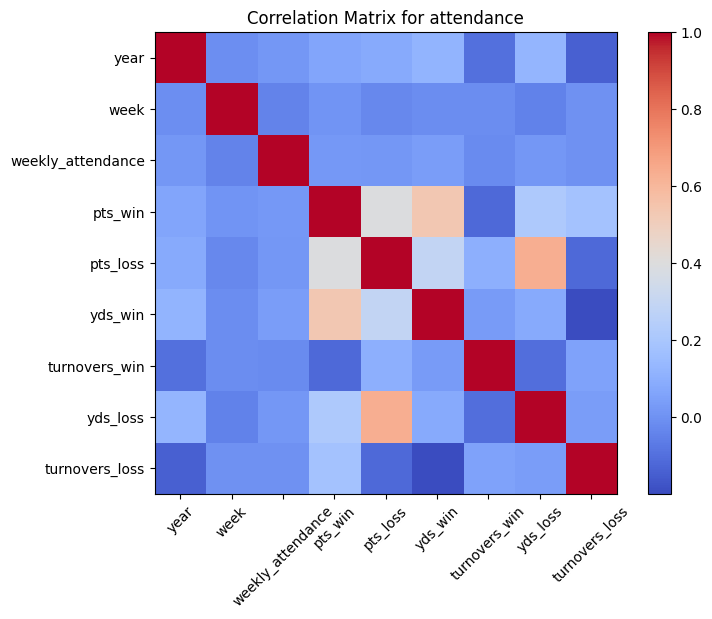

In [16]:
plt.figure(figsize=(8,6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.title("Correlation Matrix for attendance")
plt.colorbar()
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
plt.show()

In [17]:
X = df_result.drop('weekly_attendance', axis=1)
y = df_result['weekly_attendance']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [18]:
encoded_dfs_train = []
encoded_dfs_test = []
for col in to_convert_categorical:
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    encoded_train = encoder.fit_transform(X_train[[col]])
    encoded_test = encoder.transform(X_test[[col]])
    encoded_dfs_train.append(pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out([col])))
    encoded_dfs_test.append(pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out([col])))

X_train_encoded = pd.concat([X_train.drop(columns=to_convert_categorical).reset_index(drop=True)] + encoded_dfs_train, axis=1)
X_test_encoded = pd.concat([X_test.drop(columns=to_convert_categorical).reset_index(drop=True)] + encoded_dfs_test, axis=1)



      year  week  pts_win  pts_loss  yds_win  turnovers_win  yds_loss  \
0     2009    11       20        17      344              1       340   
1     2018    17       33        17      436              2       258   
2     2012     9       31        13      339              2       289   
3     2009    15       17        10      224              1       241   
4     2019    14       42        21      552              1       355   
...    ...   ...      ...       ...      ...            ...       ...   
3681  2019     6       16         0      270              1       204   
3682  2003     5       24        17      325              1       305   
3683  2014    10       21         7      312              0       210   
3684  2016    11       27        20      325              1       354   
3685  2005    11       20        17      331              2       236   

      turnovers_loss  home_team_name_49ers  home_team_name_Bears  ...  \
0                  0                   0.0        

/home/tylerbang/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/tylerbang/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/tylerbang/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/tylerbang/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse

In [19]:
model = LinearRegression()

In [20]:
param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False]
}

In [21]:
scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [22]:
grid_search = GridSearchCV(model, param_grid, scoring=scorer, cv=5)
grid_result = grid_search.fit(X_train_encoded, y_train) # enter our X and Y values here

In [23]:
best_params = grid_result.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'copy_X': True, 'fit_intercept': False}


In [24]:
best_model = grid_result.best_estimator_
y_pred = best_model.predict(X_test_encoded)

print(y_pred)
mse = mean_squared_error(y_test, y_pred)
print("Final Mean Squared Error on Test Set:", mse)

[59790.46362827 78965.177089   55306.77387259 61991.78860729
 52642.19274001 79023.41589929 69678.92773097 67685.4013109
 68928.8669074  60765.72076034 72980.02171504 69810.68781286
 65753.11707632 66454.6923668  61501.54887809 67306.02470598
 57139.7191027  77490.78630862 62021.54109678 62620.4272429
 55400.5347304  42367.6081763  77081.13319371 67264.41502418
 69774.6311622  73279.75994678 63836.15508588 72055.57991663
 72660.5471522  69931.6702586  55926.72156784 77533.71373959
 66715.12999547 77736.9445237  69349.82207652 69810.29079897
 67471.45188417 64626.95549125 66947.19361284 71987.01549657
 78254.52991291 81857.76648359 67211.62989773 61437.89876275
 61807.50719825 72268.22737239 62216.81753523 75292.58206411
 61355.87994032 61907.01754826 63472.25866555 62074.90932925
 78921.0163097  65528.78900365 73725.06654663 67900.01178388
 59605.23200456 59065.85995857 68056.15484928 66850.97037001
 61887.91356344 70196.06839829 62460.25805169 67969.60056982
 67983.09735457 78888.3028